In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from functions.Random_forest import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from functions.Pre_processing_Casos_Graves import *
from functions.Random_forest import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection._search import GridSearchCV
from sklearn.model_selection._split import StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, SelectFdr

import optuna
from sklearn.metrics import f1_score, precision_score, recall_score

Lendo o dataset

In [2]:
df = pd.read_csv(r'C:\Users\mcacs\Desktop\Estudo_dados_de_covid\Data\Casos Graves\df_casos_graves')

Utilizando a class random forest para fazer o pré processamento

In [3]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino']

In [4]:
random_forest = Random_forest(df)
random_forest.run_graves()

df = random_forest.df
df = df[list_features]
df

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.460870,0,1
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.747826,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.573913,0,1
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.591304,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.669565,0,1
36431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.643478,0,1
36432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.643478,0,1
36433,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.634783,1,0


Criando um função para executar o modelo com k-fold e com repetição

In [7]:
def SVC_model (X_train, y_train):
    param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'sigmoid']}
    """param_grid = {'C': [0.1], 
              'gamma': [1],
              'kernel': ['rbf']}"""  
    

    # Init classifier
    svc_cl = SVC()
    #gb_cl = GradientBoostingClassifier(max_depth=2, n_estimators=200, learning_rate=0.1)

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(svc_cl, param_grid, n_jobs = -1, cv=cv, scoring = "accuracy")

    # Fit 
    grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

Aplicando o modelo para diferentes random_states 

In [8]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
#list_random_states = [0,12,42,50,54,68,79,81,92,112]
list_random_states = [42]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

X = df.drop("death",axis=1)
y = df['death']


for random_state in list_random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = SVC_model(X_train,y_train)

    mean_test_scores.append(mean_test_score)
    std_test_scores.append(std_test_score)
    best_scores.append(best_score)
    best_params.append(best_param)


########################################

best_score: 0.7539385211518558
best_params_: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
########################################



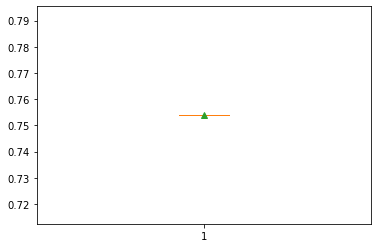

In [9]:
from matplotlib import pyplot

pyplot.boxplot(best_scores, showmeans=True)
pyplot.show()

Testando para os melhores parametros

In [10]:
print(f'Best_score = {max(best_scores)}')
index = best_scores.index(max(best_scores))
print(f'Best_params = {best_params[index]}')

Best_score = 0.7539385211518558
Best_params = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [11]:
# parametrizando o modelo final
final_cl = SVC(C=10, gamma=0.1, kernel='rbf')

#treinando o modelo final
final_cl.fit(X_train, y_train)


preds = final_cl.predict(X_test)

accuracy_score(y_test, preds)

0.7638259914916975

## APLICANDO PARA PERIODO DE 6 MESES

In [11]:
df = pd.read_csv(r'C:\Users\mcacs\Desktop\Estudo_dados_de_covid\Data\Casos Graves\df_casos_graves')

In [12]:
periodo_1 = df[(df['data_notificacao'] > '2020-02-26') & (df['data_notificacao'] < '2020-08-31')]
periodo_2 = df[(df['data_notificacao'] > '2020-09-01') & (df['data_notificacao'] < '2021-02-28')]
periodo_3 = df[(df['data_notificacao'] > '2021-03-01') & (df['data_notificacao'] < '2021-08-31')]
periodo_4 = df[(df['data_notificacao'] > '2021-09-01') & (df['data_notificacao'] < '2022-02-28')]
periodo_5 = df[(df['data_notificacao'] > '2022-03-01') & (df['data_notificacao'] < '2022-06-13')]

criando lista para armazenar as informações

In [13]:
mean_test_scores_periodos_6meses = []
std_test_scores_periodos_6meses = []
best_scores_periodos_6meses = []
best_params_periodos_6meses = []

#### Aplicando para o periodo 1

In [14]:
random_forest = Random_forest(periodo_1)
random_forest.run_graves()

df_p1 = random_forest.df
df_p1 = df_p1[list_features]
df_p1

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.486239,0,1
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.788991,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.605505,0,1
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.623853,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36273,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0.211009,1,0
36274,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.614679,0,1
36275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.623853,0,1
36276,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.752294,1,0


In [15]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores_1 = []
std_test_scores_1 = []
best_scores_1 = []
best_params_1 = []

for random_state in list_random_states:
    X = df_p1.drop("death",axis=1)
    y = df_p1['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores_1.append(mean_test_score)
    std_test_scores_1.append(std_test_score)
    best_scores_1.append(best_score)
    best_params_1.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_6meses.append(mean_test_scores_1)
std_test_scores_periodos_6meses.append(std_test_scores_1)
best_scores_periodos_6meses.append(best_scores_1)
best_params_periodos_6meses.append(best_params_1)


########################################

best_score: 0.8017257271436858
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8036497847497298
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8023595422762024
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8062920583288884
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8033825800302545
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
#######

In [16]:
print(f'Best_score = {max(best_scores_periodos_6meses[0])}')
index = best_scores_periodos_6meses[0].index(max(best_scores_periodos_6meses[0]))
print(f'Best_params = {best_params_periodos_6meses[0][index]}')

Best_score = 0.8062920583288884
Best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}


#### Aplicando periodo 2 - 6 meses

In [17]:
random_forest = Random_forest(periodo_2)
random_forest.run_graves()

df_p2 = random_forest.df
df_p2 = df_p2[list_features]
df_p2

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.736842,0,1
432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.166667,0,1
433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.798246,1,0
434,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.500000,0,1
436,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.736842,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36245,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.666667,1,0
36246,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.570175,1,0
36247,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.429825,0,1
36351,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.798246,1,0


In [18]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p2.drop("death",axis=1)
    y = df_p2['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores.append(mean_test_score)
    std_test_scores.append(std_test_score)
    best_scores.append(best_score)
    best_params.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_6meses.append(mean_test_scores)
std_test_scores_periodos_6meses.append(std_test_scores)
best_scores_periodos_6meses.append(best_scores)
best_params_periodos_6meses.append(best_params)


########################################

best_score: 0.7023174576178532
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7080086313193589
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.705642277064744
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7045342671274897
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7118743811993952
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########

In [19]:
print(f'Best_score = {max(best_scores_periodos_6meses[1])}')
index = best_scores_periodos_6meses[1].index(max(best_scores_periodos_6meses[1]))
print(f'Best_params = {best_params_periodos_6meses[1][index]}')

Best_score = 0.7118743811993952
Best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}


#### Aplicando periodo 3 - 6 meses

In [20]:
random_forest = Random_forest(periodo_3)
random_forest.run_graves()

df_p3 = random_forest.df
df_p3 = df_p3[list_features]
df_p3

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
952,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.429825,0,1
953,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.315789,1,0
954,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.368421,1,0
955,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.394737,0,1
956,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.377193,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.622807,1,0
36366,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.508772,1,0
36371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.403509,0,1
36372,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.622807,0,1


In [21]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p3.drop("death",axis=1)
    y = df_p3['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores.append(mean_test_score)
    std_test_scores.append(std_test_score)
    best_scores.append(best_score)
    best_params.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_6meses.append(mean_test_scores)
std_test_scores_periodos_6meses.append(std_test_scores)
best_scores_periodos_6meses.append(best_scores)
best_params_periodos_6meses.append(best_params)


########################################

best_score: 0.7299092783717209
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7287041853720244
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7286763137460598
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7242151463260363
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7258060916472543
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
#######

In [22]:
print(f'Best_score = {max(best_scores_periodos_6meses[2])}')
index = best_scores_periodos_6meses[2].index(max(best_scores_periodos_6meses[2]))
print(f'Best_params = {best_params_periodos_6meses[2][index]}')

Best_score = 0.7306409548345957
Best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}


#### Aplicando periodo 4 - 6 meses

In [23]:
random_forest = Random_forest(periodo_3)
random_forest.run_graves()

df_p4 = random_forest.df
df_p4 = df_p4[list_features]
df_p4

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
952,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.429825,0,1
953,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.315789,1,0
954,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.368421,1,0
955,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.394737,0,1
956,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.377193,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.622807,1,0
36366,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.508772,1,0
36371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.403509,0,1
36372,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.622807,0,1


In [24]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p4.drop("death",axis=1)
    y = df_p4['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores.append(mean_test_score)
    std_test_scores.append(std_test_score)
    best_scores.append(best_score)
    best_params.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_6meses.append(mean_test_scores)
std_test_scores_periodos_6meses.append(std_test_scores)
best_scores_periodos_6meses.append(best_scores)
best_params_periodos_6meses.append(best_params)


########################################

best_score: 0.727771102986172
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7274703465440724
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7278010315587027
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7252625538020085
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7262220679512298
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########

In [25]:
print(f'Best_score = {max(best_scores_periodos_6meses[3])}')
index = best_scores_periodos_6meses[3].index(max(best_scores_periodos_6meses[3]))
print(f'Best_params = {best_params_periodos_6meses[3][index]}')

Best_score = 0.730684448969727
Best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}


#### Aplicando periodo 5 - 6 meses

In [26]:
random_forest = Random_forest(periodo_3)
random_forest.run_graves()

df_p5 = random_forest.df
df_p5 = df_p5[list_features]
df_p5

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
952,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.429825,0,1
953,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.315789,1,0
954,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.368421,1,0
955,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.394737,0,1
956,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.377193,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.622807,1,0
36366,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.508772,1,0
36371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.403509,0,1
36372,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.622807,0,1


In [27]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p5.drop("death",axis=1)
    y = df_p5['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores.append(mean_test_score)
    std_test_scores.append(std_test_score)
    best_scores.append(best_score)
    best_params.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_6meses.append(mean_test_scores)
std_test_scores_periodos_6meses.append(std_test_scores)
best_scores_periodos_6meses.append(best_scores)
best_params_periodos_6meses.append(best_params)


########################################

best_score: 0.7279147498495858
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.727785789584651
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7256781392861368
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.723813177828173
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7274988249692744
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
#########

In [28]:
print(f'Best_score = {max(best_scores_periodos_6meses[4])}')
index = best_scores_periodos_6meses[4].index(max(best_scores_periodos_6meses[4]))
print(f'Best_params = {best_params_periodos_6meses[4][index]}')

Best_score = 0.7311720584378518
Best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}


### Análise geral periodos de 6 meses 

In [23]:
from statistics import mean

print(f'Maior score: {max(best_scores_periodos_6meses)} \nMenor Score: {min(best_params_periodos_6meses)} \nMedia Scores: {mean(best_params_periodos_6meses)} ')
print(f'Desvio padrão médio: {mean(std_test_scores_periodos_6meses)} ')

TypeError: '<' not supported between instances of 'dict' and 'dict'

In [ ]:
pyplot.boxplot(best_scores_periodos_6meses, showmeans=True)
pyplot.show()

## APLICANDO PARA PERIODO DE 3 MESES

In [29]:
df = pd.read_csv(r'C:\Users\mcacs\Desktop\Estudo_dados_de_covid\Data\Casos Graves\df_casos_graves')

In [30]:
periodo_1 = df[(df['data_notificacao'] > '2020-02-26') & (df['data_notificacao'] < '2020-05-31')]
periodo_2 = df[(df['data_notificacao'] > '2020-06-01') & (df['data_notificacao'] < '2020-08-31')]
periodo_3 = df[(df['data_notificacao'] > '2020-09-01') & (df['data_notificacao'] < '2020-11-30')]
periodo_4 = df[(df['data_notificacao'] > '2020-12-01') & (df['data_notificacao'] < '2021-02-28')]
periodo_5 = df[(df['data_notificacao'] > '2021-03-01') & (df['data_notificacao'] < '2021-05-31')]
periodo_6 = df[(df['data_notificacao'] > '2021-06-01') & (df['data_notificacao'] < '2021-08-31')]
periodo_7 = df[(df['data_notificacao'] > '2021-09-01') & (df['data_notificacao'] < '2021-11-30')]
periodo_8 = df[(df['data_notificacao'] > '2021-12-01') & (df['data_notificacao'] < '2022-02-28')]
periodo_9 = df[(df['data_notificacao'] > '2022-03-01') & (df['data_notificacao'] < '2025-05-31')]
periodo_10 = df[(df['data_notificacao'] > '2022-06-01') & (df['data_notificacao'] < '2022-06-13')]

In [31]:
mean_test_scores_periodos_3mese = []
std_test_scores_periodos_3meses = []
best_scores_periodos_3meses = []
best_params_periodos_3meses = []

#### Aplicando para perido 1 - 3 meses

In [32]:
random_forest = Random_forest(periodo_1)
random_forest.run_graves()

df_p1 = random_forest.df
df_p1 = df_p1[list_features]
df_p1

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.486239,0,1
24,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.633028,0,1
25,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.642202,0,1
26,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.596330,0,1
27,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.467890,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36271,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.532110,1,0
36272,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.871560,1,0
36274,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.614679,0,1
36275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.623853,0,1


In [33]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p1.drop("death",axis=1)
    y = df_p1['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores_1.append(mean_test_score)
    std_test_scores_1.append(std_test_score)
    best_scores_1.append(best_score)
    best_params_1.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_3mese.append(mean_test_scores)
std_test_scores_periodos_3meses.append(std_test_scores)
best_scores_periodos_3meses.append(best_scores)
best_params_periodos_3meses.append(best_params)


########################################

best_score: 0.8349617486338797
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8354754098360655
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8315737704918034
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8306448087431693
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.8341202185792349
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
#######

In [34]:
print(f'Best_score = {max(best_scores_periodos_3meses[0])}')
index = best_scores.index(max(best_scores_periodos_3meses[0]))
print(f'Best_params = {best_params_periodos_3meses[0][index]}')

ValueError: max() arg is an empty sequence

#### Aplicando periodo 2 - 3 meses

In [35]:
random_forest = Random_forest(periodo_2)
random_forest.run_graves()

df_p2 = random_forest.df
df_p2 = df_p2[list_features]
df_p2

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.803738,1,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.635514,0,1
5,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.869159,0,1
6,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.626168,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36251,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.644860,1,0
36252,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.654206,1,0
36261,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.747664,0,1
36270,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.766355,1,0


In [37]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p2.drop("death",axis=1)
    y = df_p2['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores_1.append(mean_test_score)
    std_test_scores_1.append(std_test_score)
    best_scores_1.append(best_score)
    best_params_1.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_3mese.append(mean_test_scores)
std_test_scores_periodos_3meses.append(std_test_scores)
best_scores_periodos_3meses.append(best_scores)
best_params_periodos_3meses.append(best_params)


########################################

best_score: 0.7631794819149301
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7633098928925846
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7712869999657803
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7648802313246417
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
########################################

########################################

best_score: 0.7740577969407658
best_params_: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4}
#######

In [ ]:
print(f'Best_score = {max(best_scores_periodos_3meses[1])}')
index = best_scores.index(max(best_scores_periodos_3meses[1]))
print(f'Best_params = {best_params_periodos_3meses[1][index]}')

#### Aplicando periodo 3 - 3 meses

In [ ]:
random_forest = Random_forest(periodo_3)
random_forest.run_graves()

df_p3 = random_forest.df
df_p3 = df_p3[list_features]
df_p3

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.807692,0,1
432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.182692,0,1
433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.875000,1,0
434,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.548077,0,1
436,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.807692,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36168,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0.576923,1,0
36169,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.586538,0,1
36235,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0.605769,0,1
36236,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0.519231,0,1


In [ ]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [0,12,42,50,54,68,79,81,92,112]

#listas para armazenar os resutados
mean_test_scores = []
std_test_scores = []
best_scores = []
best_params = []

for random_state in list_random_states:
    X = df_p3.drop("death",axis=1)
    y = df_p3['death']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    mean_test_score, std_test_score, best_score, best_param = GradientBoosting_model(X_train,y_train)

    mean_test_scores_1.append(mean_test_score)
    std_test_scores_1.append(std_test_score)
    best_scores_1.append(best_score)
    best_params_1.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
mean_test_scores_periodos_3mese.append(mean_test_scores)
std_test_scores_periodos_3meses.append(std_test_scores)
best_scores_periodos_3meses.append(best_scores)
best_params_periodos_3meses.append(best_params)


In [ ]:
print(f'Best_score = {max(best_scores_periodos_3meses[2])}')
index = best_scores.index(max(best_scores_periodos_3meses[2]))
print(f'Best_params = {best_params_periodos_3meses[2][index]}')